# Non statistical Analysis of the data

## Importation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

## Extraction des données

In [3]:
# Paramètres des données
Stations = ['Aigle', 'Pully', 'Payerne', 'Fretaz', 'Dole', 'Nyon']
stat_index = 1
Format = ['Minutes','Heures']
form_index = 0

# Importation et fusion des années 80-95 et 95-24
file_path1 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'8095.txt'
file_path2 = '../Database/Precipitations/Data'+Stations[stat_index]+Format[form_index]+'/Data'+Stations[stat_index]+Format[form_index][0]+'9524.txt'

df = pd.read_csv(file_path1, sep=";", low_memory=False)
df_temp = pd.read_csv(file_path2, sep=";", low_memory=False)

Overlap_num = df['time'].max()
df_temp = df_temp[df_temp['time'] > Overlap_num]
df = pd.concat([df, df_temp], ignore_index=True)

# Epuration des données et temps/value en format adapté
del df_temp
del df['stn']
df = df.replace('-',0.0)
df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H%M')
df = df[~df['time'].dt.year.isin([1980, 2025])]
df = df.reset_index(drop=True)

value_column = df.columns[1]
df[value_column] = pd.to_numeric(df[value_column], errors='coerce')

# Gestion des moyennes et maximas par an
n = 1

rows_to_keep = len(df) - (len(df) % n)
df = df.iloc[:rows_to_keep]
df['group'] = np.floor(df.index / n)
df['averaged'] = df.groupby('group')[value_column].mean()*6
df['year'] = df['time'].dt.year
pdmaximas = df.groupby('year')['averaged'].max()

# Gestion des données en Numpy

In [4]:
maximas = np.array(pdmaximas)
values = df['averaged'].dropna().to_numpy()
lv = len(values)
time = np.arange(0,lv,1)
time_in_years = time*n/(6*24*366)+1981


# Moyenne mobile

In [5]:
m = 6

moyenne_mob = np.convolve(values,np.ones(m)/m,mode='same')

### Plot moyenne mobile

(1980.0, 2025.0)

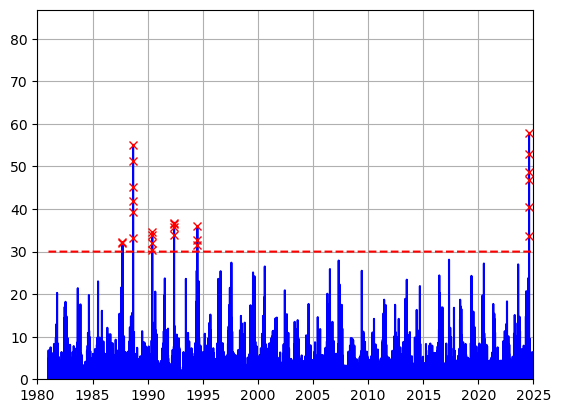

In [6]:
treshold = 30

plt.figure()
plt.plot(time_in_years, moyenne_mob,'b-')
plt.plot(time_in_years,treshold*np.ones(len(time_in_years)),'r--')
plt.plot(time_in_years[moyenne_mob>treshold],moyenne_mob[moyenne_mob>treshold],'rx')
plt.grid('on')
plt.ylim(0,1.5*moyenne_mob.max())
plt.xlim(1980,2025)



# Cumulative

In [7]:
def Cumulative(time_serie, damping, inertia_ratio=0):
    cumul = 0
    cumulative = np.zeros(len(time_serie))
    inertia = 0
    for i,t in enumerate(time_serie):
        if t!=0:
            cumul += t*(1-inertia)
            if inertia >= -1 + inertia_ratio:
                inertia -= inertia_ratio
        elif cumul - damping < 0:
            cumul = 0
        else: 
            cumul -= damping*(1+inertia)
            if inertia <= 1 - inertia_ratio:
                inertia += inertia_ratio
        cumulative[i] = cumul
    return cumulative

### Plot cumulative

(1980.0, 2025.0)

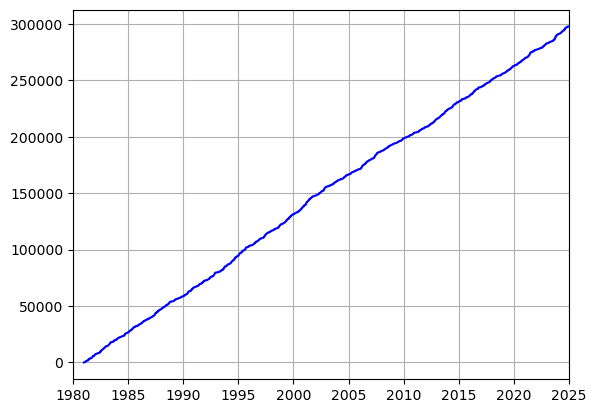

In [8]:
cumulative = Cumulative(values,damping=0.0,inertia_ratio=0.0)

plt.figure()
plt.plot(time_in_years, cumulative, 'b')
plt.grid('on')
plt.xlim(1980,2025)

## Cumulative par année

In [9]:
years = sorted(df['year'].unique())
rain_per_year = [df.loc[df['year'] == y, value_column].values for y in years]
maxlenyear = max(len(r) for r in rain_per_year)

rain_matrix = np.zeros(shape=[len(years), maxlenyear])
Cumulatives = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes = np.zeros(shape=[len(years), maxlenyear])
Cumulative_slopes_conv = np.zeros(shape=[len(years), maxlenyear])

slope_interval = 6*24*7
m = 6*24*21

for i, r in enumerate(rain_per_year):
    rain_matrix[i, :len(r)] = r
    Cumulatives[i, :len(r)] = Cumulative(rain_matrix[i, :len(r)], damping=0.0, inertia_ratio=0.0)
    for j, k in enumerate(Cumulatives[i, :(len(r)-slope_interval)]):
        Cumulative_slopes[i, j] = (Cumulatives[i, j+slope_interval] - Cumulatives[i,j])/slope_interval
    Cumulative_slopes_conv[i] = np.convolve(Cumulative_slopes[i], np.ones(m)/m, mode='same')

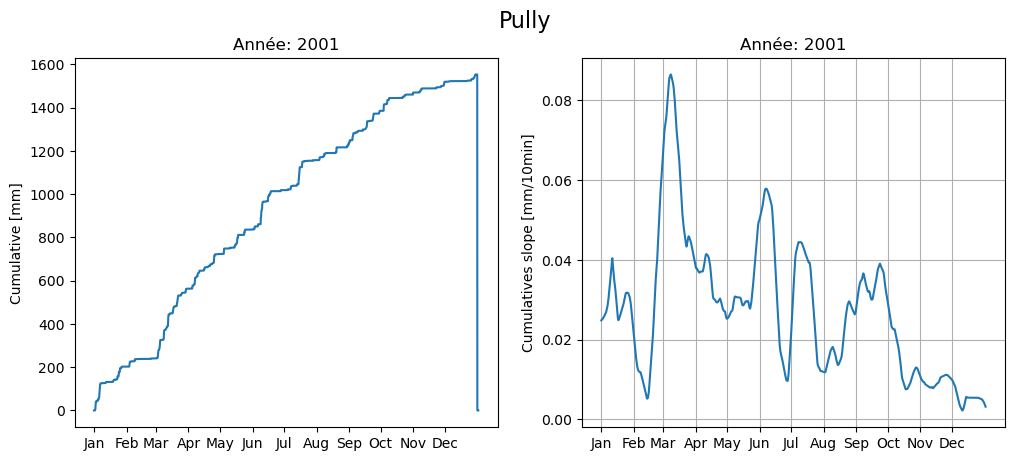

In [10]:
year = 20

month_starts = np.cumsum([0] + [calendar.monthrange(1981+year, m)[1] for m in range(1, 12)])
month_labels = [calendar.month_abbr[m] for m in range(1, 13)]

figs, axs = plt.subplots(1,2)
figs.set_figwidth(12)

axs[0].plot(np.arange(maxlenyear)/(6*24), Cumulatives[year])
axs[0].set_xticks(month_starts)
axs[0].set_xticklabels(month_labels)
axs[0].set_ylabel('Cumulative [mm]')

axs[1].plot(np.arange(maxlenyear)/(6*24), Cumulative_slopes_conv[year])
axs[1].set_xticks(month_starts)
axs[1].set_xticklabels(month_labels)
axs[1].set_ylabel('Cumulatives slope [mm/10min]')

axs[0].set_title(f'Année: {year+1981}')
axs[1].set_title(f'Année: {year+1981}')
plt.suptitle(Stations[stat_index], fontsize=16)
plt.grid('on')



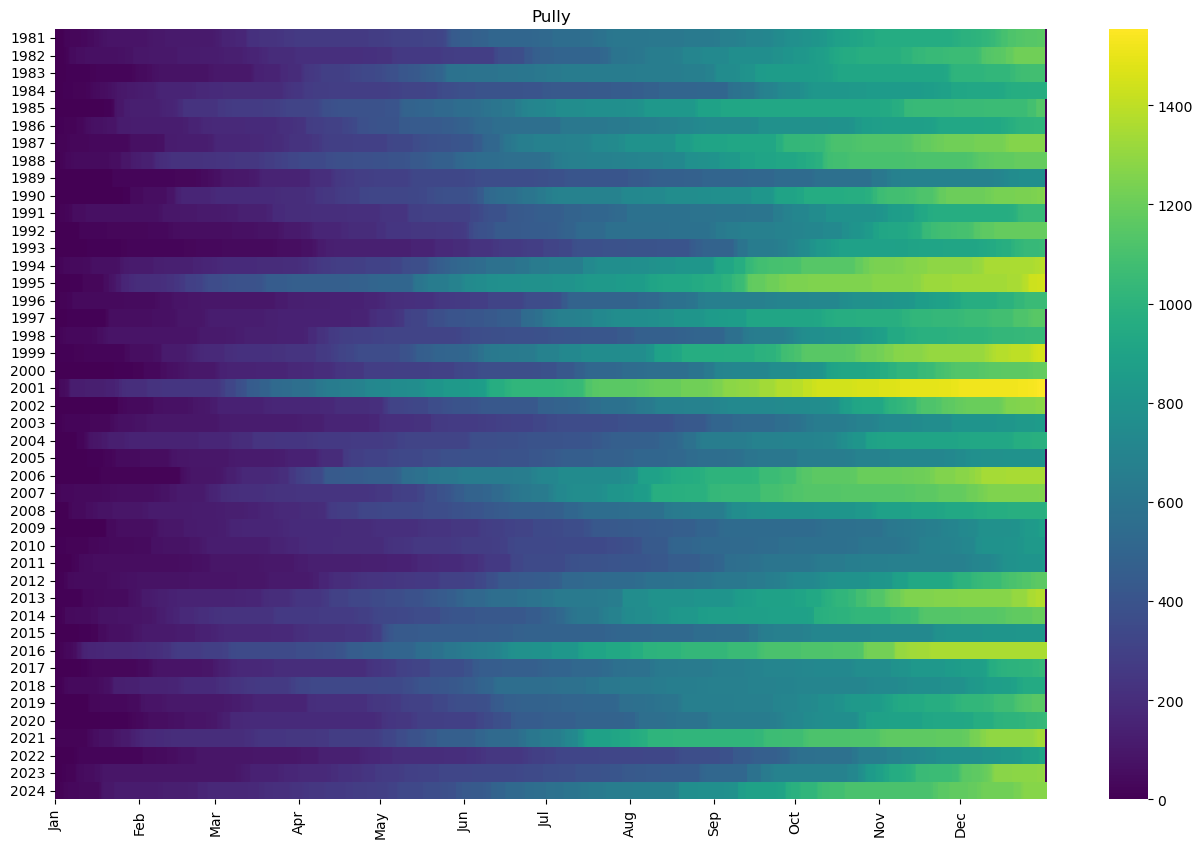

In [11]:
month_starts = np.cumsum([0] + [6*24*calendar.monthrange(1981+year, m)[1] for m in range(1, 12)])

plt.figure(figsize=(16,10))
ax = sns.heatmap(Cumulatives, yticklabels=1981+np.arange(0,len(years)), cmap = 'viridis')
ax.set_xticks(month_starts)
ax.set_xticklabels(month_labels)
plt.title(Stations[stat_index])
plt.show()

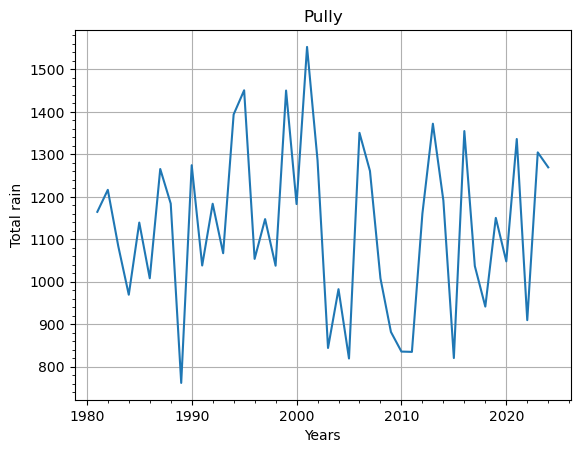

In [12]:
max_cumulatives = np.max(Cumulatives, axis=1)
plt.plot(years, max_cumulatives)
plt.grid(True)
plt.xlabel('Years')
plt.ylabel('Total rain')
plt.title(Stations[stat_index])
plt.minorticks_on()

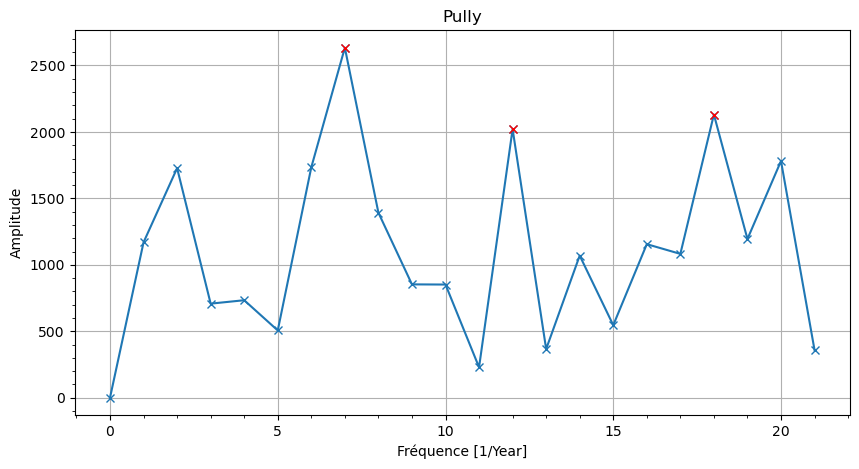

In [13]:
# Calcul de la FFT
max_cumulatives = max_cumulatives - np.mean(max_cumulatives)
fft_vals = np.fft.fft(max_cumulatives)
fft_freqs = np.fft.fftfreq(len(max_cumulatives), 1/len(years))

# On prend seulement la partie positive
half_n = len(max_cumulatives) // 2
fft_vals = np.abs(fft_vals[:half_n])
fft_freqs = fft_freqs[:half_n]

plt.figure(figsize=(10, 5))
plt.plot(fft_freqs, fft_vals, 'x-')
plt.plot(fft_freqs[fft_vals>np.max(fft_vals*0.75)], fft_vals[fft_vals>np.max(fft_vals*0.75)], 'xr')
plt.title("Spectre de fréquence")
plt.xlabel("Fréquence [1/Year]")
plt.ylabel("Amplitude")
plt.title(Stations[stat_index])
plt.minorticks_on()
plt.grid(True)
plt.show()

In [14]:
width_mobile = 30
num_mobile = np.max(years)-np.min(years)-width_mobile
num_max_values = 3

ffts_vals = np.zeros(shape=[num_mobile, width_mobile//2])
ffts_freqs = np.zeros(shape=[num_mobile, width_mobile//2])
amplitudes_max = np.zeros(shape=[num_mobile, num_max_values])
frequencies_max = np.zeros(shape=[num_mobile, num_max_values])

for i in range(num_mobile):
    signal_mobile = max_cumulatives[i:i+width_mobile]
    signal_mobile = (signal_mobile-np.mean(signal_mobile))/np.std(signal_mobile)
    fft_temp_val = np.fft.fft(signal_mobile)
    fft_temp_freq = np.fft.fftfreq(len(signal_mobile), 1/len(years))
    half_n = len(signal_mobile) // 2
    ffts_vals[i] = np.abs(fft_temp_val[:half_n])
    ffts_freqs[i] = fft_temp_freq[:half_n]
    max_vals_index = np.argsort(ffts_vals[i])[-num_max_values:][::-1]
    amplitudes_max[i] = ffts_vals[i][max_vals_index]
    frequencies_max[i] = ffts_freqs[i][max_vals_index]

[]

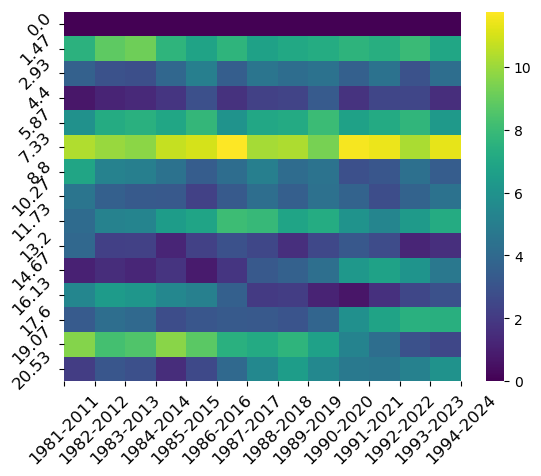

In [15]:
x_labels = [f"{np.min(years)+i}-{np.min(years)+i+width_mobile}" for i in range(len(years)-width_mobile)]

ax = sns.heatmap(ffts_vals.transpose(), cmap='viridis')
ax.set_yticklabels(np.round(ffts_freqs[0],2), rotation=45, fontsize=12)
ax.set_xticks(np.arange(num_mobile+1))
ax.set_xticklabels(x_labels, rotation=45, fontsize=12)
ax.plot()